In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.10.0


In [2]:
# Importing dataset
dataset = np.load('char_normalized_dataset.npz')
X = dataset['x']
Y = dataset['y']
print(X.shape)
print(Y.shape)

(230, 14, 1536)
(230,)


In [3]:
# Since this work is trying to create a model that is robust to every user we will be
# Splitting the dataset with Scikit-Learn Train-Test split.
# Further work can test if diferent splitting techniques enhance performance of the model
# e.g split acording to subjects/labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=SEED)

print(f'''
X_train shape:{X_train.shape} -> Train Labels: {y_train.shape[0]}
X_test shape:{X_test.shape} -> Test Labels: {y_test.shape[0]}''')


X_train shape:(184, 14, 1536) -> Train Labels: 184
X_test shape:(46, 14, 1536) -> Test Labels: 46


In [4]:
# Veriffing label distribution of train and test samples
display('Train Label distribution', pd.DataFrame(y_train, columns=['label']).groupby(['label'])['label'].count())
display('Test Label distribution', pd.DataFrame(y_test, columns=['label']).groupby(['label'])['label'].count())

'Train Label distribution'

label
0.0    19
1.0    17
2.0    19
3.0    19
4.0    20
5.0    18
6.0    18
7.0    19
8.0    17
9.0    18
Name: label, dtype: int64

'Test Label distribution'

label
0.0    4
1.0    6
2.0    4
3.0    4
4.0    3
5.0    5
6.0    5
7.0    4
8.0    6
9.0    5
Name: label, dtype: int64

In [5]:
# Creating our Transformer from a pre-trained model Transfer-Learn
## Based on https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=JuxDkcvVIoev

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# TensorFlow models and layers in transformers accept two formats as input:
# having all inputs as keyword arguments (like PyTorch models), or
# having all inputs as a list, tuple or dict in the first positional argument.

ds_train_TL = list(zip(X_train, y_train))
ds_test_TL = list(zip(X_test, y_test))

In [6]:
# Selecting a pre-trained model from Tensorflow Hub

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

In [7]:
# Create a preprocess layer

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
# Building our classifier

def build_classifier_model():
  EEG_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='EEG')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='Preprocessing')
  encoder_inputs = preprocessing_layer(EEG_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(net)
  return tf.keras.Model(EEG_input, net)

classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EEG (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 Preprocessing (KerasLayer)     {'input_type_ids':   0           ['EEG[0][0]']                    
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

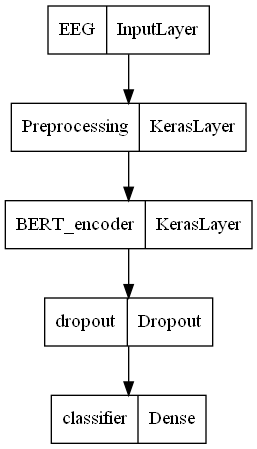

In [9]:
tf.keras.utils.plot_model(classifier_model)

In [10]:
EPOCHS = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [11]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [12]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [13]:
print(f'Training model with BERT_Multi_Cased_L-12_H-768_A-12')
history = classifier_model.fit(x = X_train,
                               y = y_train,
                               validation_data = (X_test, y_test),
                               epochs= EPOCHS)

Training model with BERT_Multi_Cased_L-12_H-768_A-12
Epoch 1/5


ValueError: in user code:

    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\WILLIA~1\AppData\Local\Temp\__autograph_generated_filen4cnfuee.py", line 74, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
    File "C:\Users\WILLIA~1\AppData\Local\Temp\__autograph_generated_filen4cnfuee.py", line 72, in else_body_3
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact((lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope))), ag__.autograph_artifact((lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope)))), None, fscope)
    File "C:\Users\WILLIA~1\AppData\Local\Temp\__autograph_generated_filen4cnfuee.py", line 72, in <lambda>
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact((lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope))), ag__.autograph_artifact((lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope)))), None, fscope)

    ValueError: Exception encountered when calling layer "Preprocessing" "                 f"(type KerasLayer).
    
    in user code:
    
        File "c:\Users\Willian Oliveira\anaconda3\envs\tf_py\lib\site-packages\tensorflow_hub\keras_layer.py", line 237, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (3 total):
            * <tf.Tensor 'inputs:0' shape=(None, 14, 1536) dtype=string>
            * False
            * None
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * True
            * None
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
            * False
            * None
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * False
            * None
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (3 total):
            * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
            * True
            * None
          Keyword arguments: {}
    
    
    Call arguments received by layer "Preprocessing" "                 f"(type KerasLayer):
      • inputs=tf.Tensor(shape=(None, 14, 1536), dtype=string)
      • training=True


In [ ]:
ds_train_TL[0]

In [ ]:
# Creating our Transformer from Scratch
## Based on https://github.com/Kyubyong/transformer